## Import Data into a Graph

We've done a lot of upfront work that makes reading data into graph-tool easy: indexing our nodes, and describing our edges as relationships between indexed nodes.

Below we'll read in our nodes and edges data we created. We'll create a new variable on our edges called `n_weights`, which is the number of unique types of connections (weights) between nodes. Example: If `UserA` has only retweeted `UserB`, this value is 1. If `UserA` has RT, replied, and mentioned `UserB`, this value is 3.

We'll also recreate our node mapping and our edge mapping so that we can always refer back to attributes of our original data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import graph_tool.all as gt
%matplotlib inline

In [2]:
nodes = pd.read_csv("./data/nodes.csv", index_col=0)
edges = pd.read_csv("./data/edge_weights.csv", index_col=0)

In [3]:
edges["n_weights"] = (edges[["rt_weight", "reply_weight", "mention_weight"]] > 0).sum(axis="columns")

In [4]:
node_map = {row.index : row.userid for row in nodes.itertuples()}
node_map_inv = {v : k for (k, v) in node_map.items()}

edge_map = {row.Index : (row.source_id, row.target_id) for row in edges.itertuples()}
edge_map_inv = {v : k for (k, v) in edge_map.items()}

In [5]:
rt_weights, reply_weights, mention_weights, n_weights = {}, {}, {}, {}

for edge in edges.itertuples():
    rt_weights[(edge.source_id, edge.target_id)] = edge.rt_weight
    reply_weights[(edge.source_id, edge.target_id)] = edge.reply_weight
    mention_weights[(edge.source_id, edge.target_id)] = edge.mention_weight
    n_weights[(edge.source_id, edge.target_id)] = edge.n_weights

## Creating a Graph

Creating a graph using `graph-tool` requires three steps:
1. Creating the `Graph` object.
2. Creating all the nodes with `add_vertex()` method. Passing a value to this method creates that number of indexed vertices.
3. Adding edges with the `add_edge()` method. This takes `Vertex` objects as arguments (not the indices of the vertices).

In [6]:
g = gt.Graph()
g.add_vertex(len(node_map))
for edge in edge_map:
    source, target = edge_map[edge]
    g.add_edge(g.vertex(source), g.vertex(target))

## Drawing a Graph
One of the nice features of `graph-tool` is the drawing API. Drawing a graph requires a layout, which is an algorithmically determined way to place nodes. We'll create a layout, then plot the graph below and do some brief visual analysis based on the results.

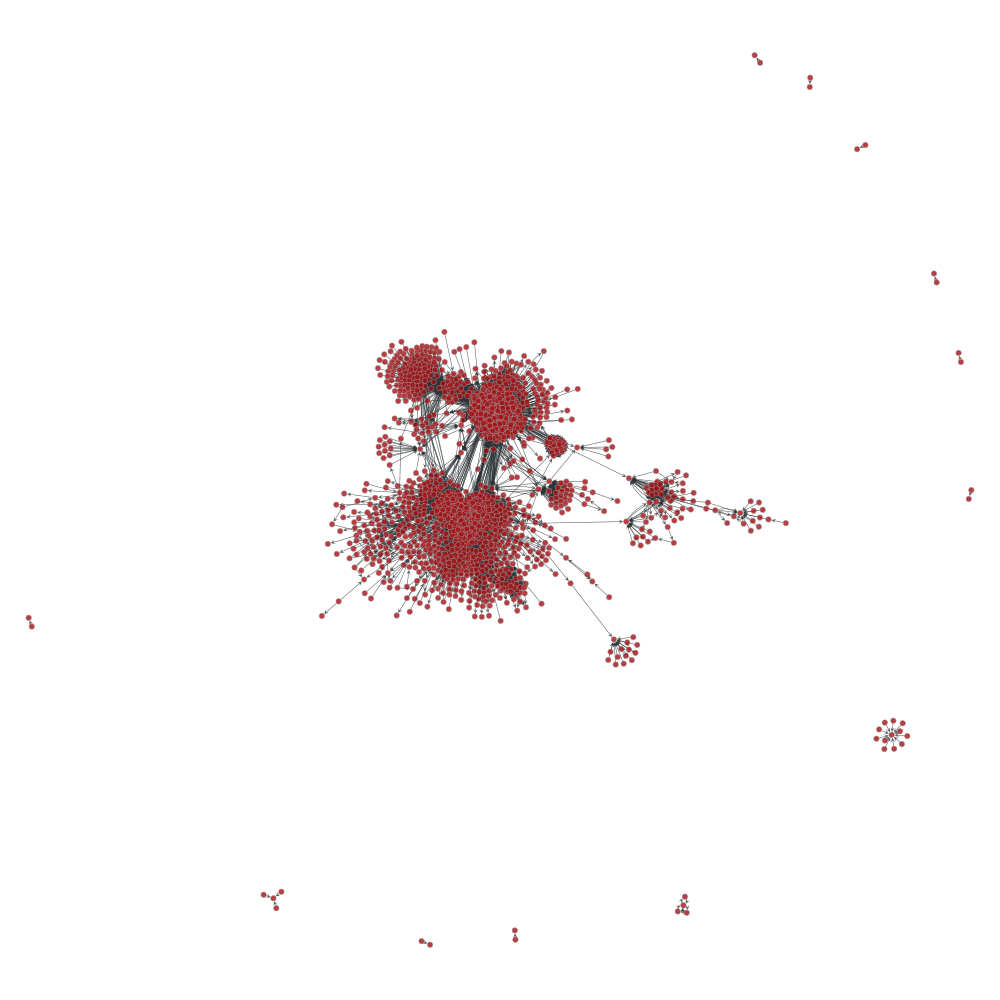

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7efd722dcd68, at 0x7efdb7e741d0>

In [7]:
pos = gt.sfdp_layout(g)
gt.graph_draw(g, pos=pos, output_size=(1000,1000))

### Network Discussion

Because of the layout algorithm, we can infer some properties of the network based upon how nodes are laid out. For example, nodes that have reciporical relationships are going to be pulled together. A group of these nodes will be densely connected, whereas 
I would describe the general structure of the network in a few ways:
1. There is one large, central part of the network that relates most of the accounts to each other.
2. This large, central network can be broken out into two, densely connected groups.
3. Nodes that are connected to the central network, but appear on the periphery, are accounts that had a RT/reply/mention from an account in the central network, but did not reciporicate an interaction.
4. There are 12 smaller groups with interactions around the periphery that are not connected to the central group of accounts.

For the remainder of the analysis, we'll focus on the large central group. Before we get there, we need to talk about how to add attributes to the nodes and edges of our graph.

## PropertyMaps with GraphTool

`PropertyMap`s are one of the parts of `graph-tool` that took me a while to understand. They're a way to assign attributes to a node, an edge, or the graph itself. Here are a few things to note:
1. You have to declare a type for the property. You can find available properties [here](https://graph-tool.skewed.de/static/doc/quickstart.html#property-maps). For example, our `userid` property will be of type `"string"`. 
2. Despite calling the `new_<vertex/edge>_property()` method from the graph object, the property map object isn't "attached" to the graph itself: it's a distinct description about the nodes or edges for a specific graph. If you copy a graph or create a subgraph, the original map still only applies to the original graph. However, you can make a `PropertyMap` "internal" to a graph, such that whenever you save the graph or create a subgraph, the properties come with it.
3. It's typically easiest to add properties with the `vals=` argument. This will also require you to have your properties indexed and in the same order as your nodes and edges. This is why we did this up front during data cleaning.

We'll create edge properties based off of our weight variables. We'll also create logarithmic versions of our weights, which are helpful when doing analysis and visualizations.

In [8]:
# Vertex Properties
vertex_name = g.new_vertex_property("string", vals=nodes['userid'].values)

# Edge Properties (Weights)
rt_weights_pm = g.new_edge_property("float", vals=[i[1] for i in sorted(rt_weights.items())])
reply_weights_pm = g.new_edge_property("float", vals=[i[1] for i in sorted(reply_weights.items())])
mention_weights_pm = g.new_edge_property("float", vals=[i[1] for i in sorted(mention_weights.items())])
n_weights_pm = g.new_edge_property("float", vals=[i[1] for i in sorted(n_weights.items())])

## Log Edge Properties
rt_weights_log_pm = g.new_edge_property("float", vals=[np.log1p(i[1]) for i in sorted(rt_weights.items())])
reply_weights_log_pm = g.new_edge_property("float", vals=[np.log1p(i[1]) for i in sorted(reply_weights.items())])
mention_weights_log_pm = g.new_edge_property("float", vals=[np.log1p(i[1]) for i in sorted(mention_weights.items())])

# Make Property Maps Internal to Graph
g.vertex_properties["vertex_name"] = vertex_name

g.edge_properties["rt_weights"] = rt_weights_pm
g.edge_properties["reply_weights"] = reply_weights_pm
g.edge_properties["mention_weights"] = mention_weights_pm
g.edge_properties["n_weights"] = n_weights_pm

g.edge_properties["rt_weights_log"] = rt_weights_log_pm
g.edge_properties["reply_weights_log"] = reply_weights_log_pm
g.edge_properties["mention_weights_log"] = mention_weights_log_pm

In [9]:
## Verify Properties are on Graph
g.list_properties()

vertex_name    (vertex)  (type: string)
mention_weights (edge)    (type: double)
mention_weights_log (edge)    (type: double)
n_weights      (edge)    (type: double)
reply_weights  (edge)    (type: double)
reply_weights_log (edge)    (type: double)
rt_weights     (edge)    (type: double)
rt_weights_log (edge)    (type: double)


## Create Subgraph & Visualize

We're going to use a feature called a `GraphView` -- this is similar to a View in the database sense: it can represent a subgraph or specific version of the original graph data, but without creating a new Graph (i.e. a new Table). Our subgraph is going to be built out of the [largest connected component](https://en.wikipedia.org/wiki/Connected_component_(graph_theory)). Despite our graph being directed, we're going to pass `directed=False` to the `label_largest_component` function, because we want to include those nodes that are on the periphery of the large component.

Though `GraphViews` are typically helpful because they don't create a whole new graph, we are going to create new graph from our view, since we're going to operate with it for the rest of our analysis.

After creating the subgraph, we'll create a new layout and draw it.

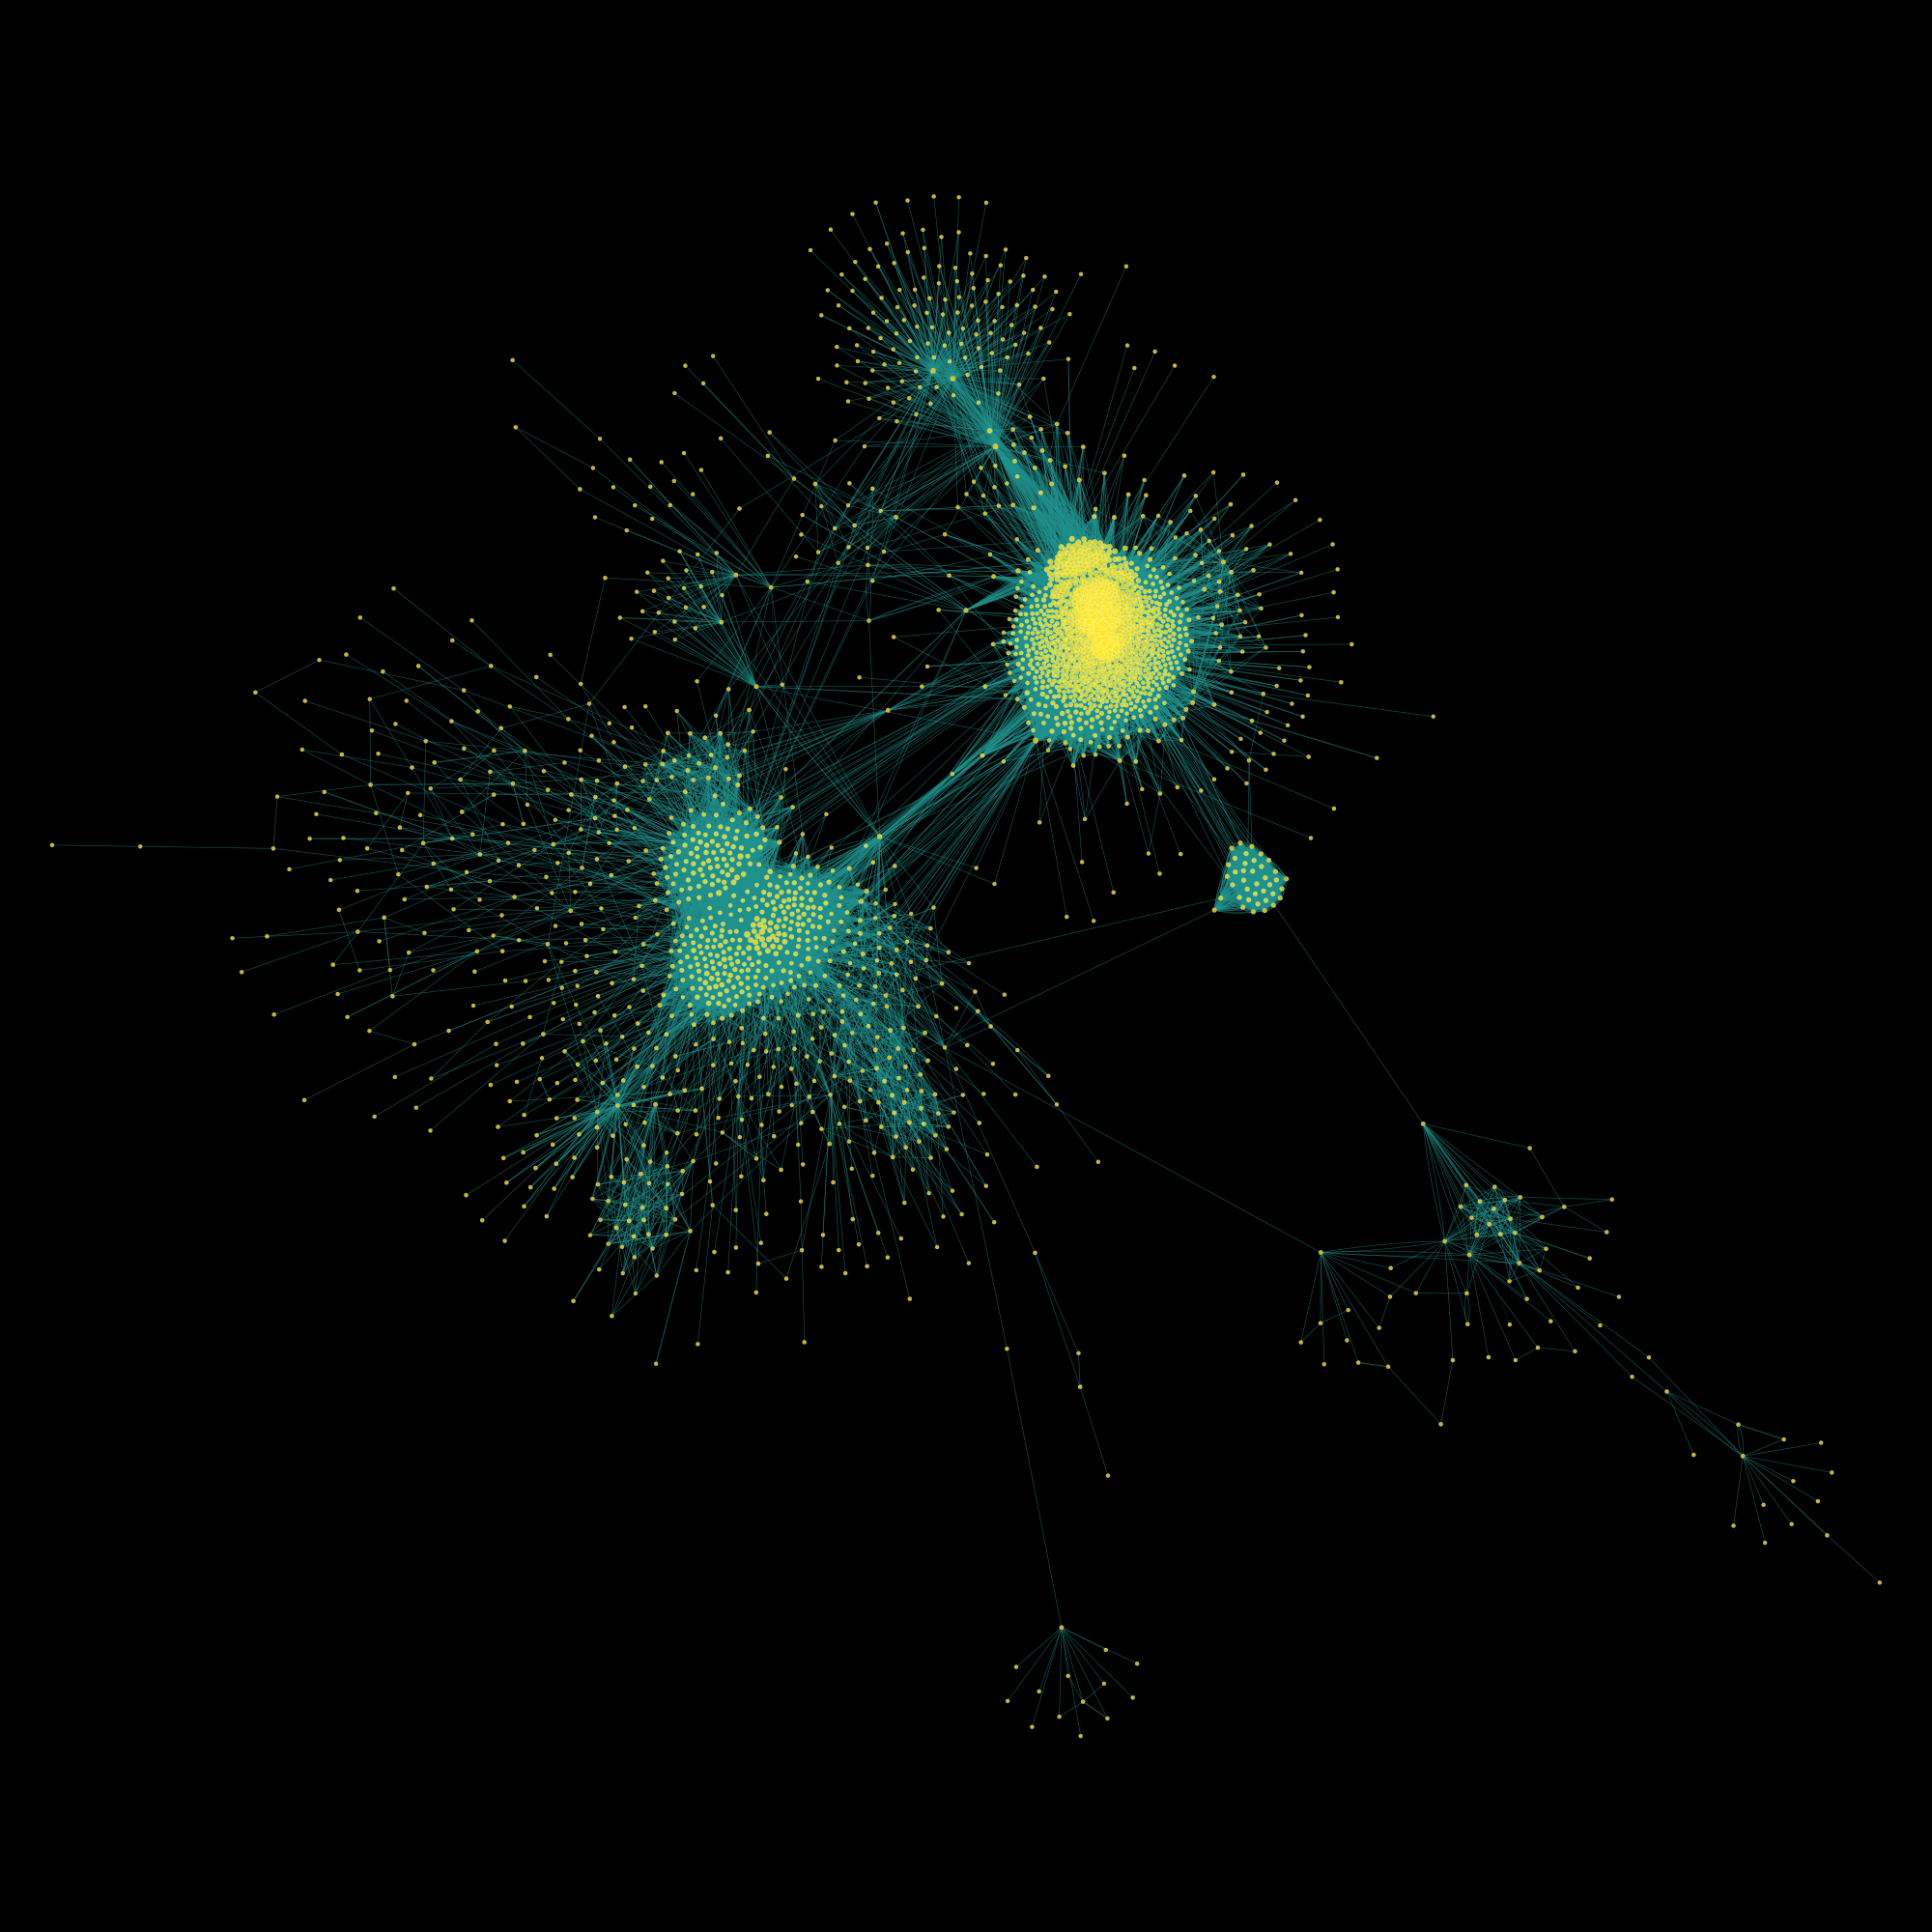

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7efd71c92630, at 0x7efd71c96f60>

In [10]:
# don't want strongly connected components
largest_comp = gt.GraphView(g, vfilt=gt.label_largest_component(g, directed=False))
largest_comp = gt.Graph(largest_comp, prune=True)

pos = gt.sfdp_layout(largest_comp)

deg = largest_comp.degree_property_map("in")

gt.graph_draw(
    largest_comp,
    pos=pos,
    output_size=(2000, 2000),
    vertex_fill_color=[*matplotlib.cm.viridis.colors[-1], .8],
    vertex_size=gt.prop_to_size(deg, mi=4, ma=8),
    vertex_color=[1, 1, 1, 0.5],
    edge_color=[*matplotlib.cm.viridis.colors[128], .6],
    edge_pen_width=gt.prop_to_size(largest_comp.ep["n_weights"], mi=0.2, ma=1, power=1),
    bg_color=[0, 0, 0, 1],
)

### Save position PropertyMap to Graph
The positions of the nodes for the layout, calculated by `gt.sfdp_layout()` and stored in `pos`, are stored as a PropertyMap. In order to continue using these positions in future visualizations after we save the graph, we should make this map internal to the graph.

In [11]:
largest_comp.vertex_properties["pos"] = pos

## Customizing the visualization
The `n_weights` property represents the number of unique interactions between accounts. We'll use this to color the edges to see if we can detect any patterns in groups of accounts that had more unique interaction.

Most nodes are connected through two distinct interactions, so we should expect to see this in the visualization.

In [12]:
print(edges['n_weights'].value_counts(sort=False))

1      2195
2    169960
3      8860
Name: n_weights, dtype: int64


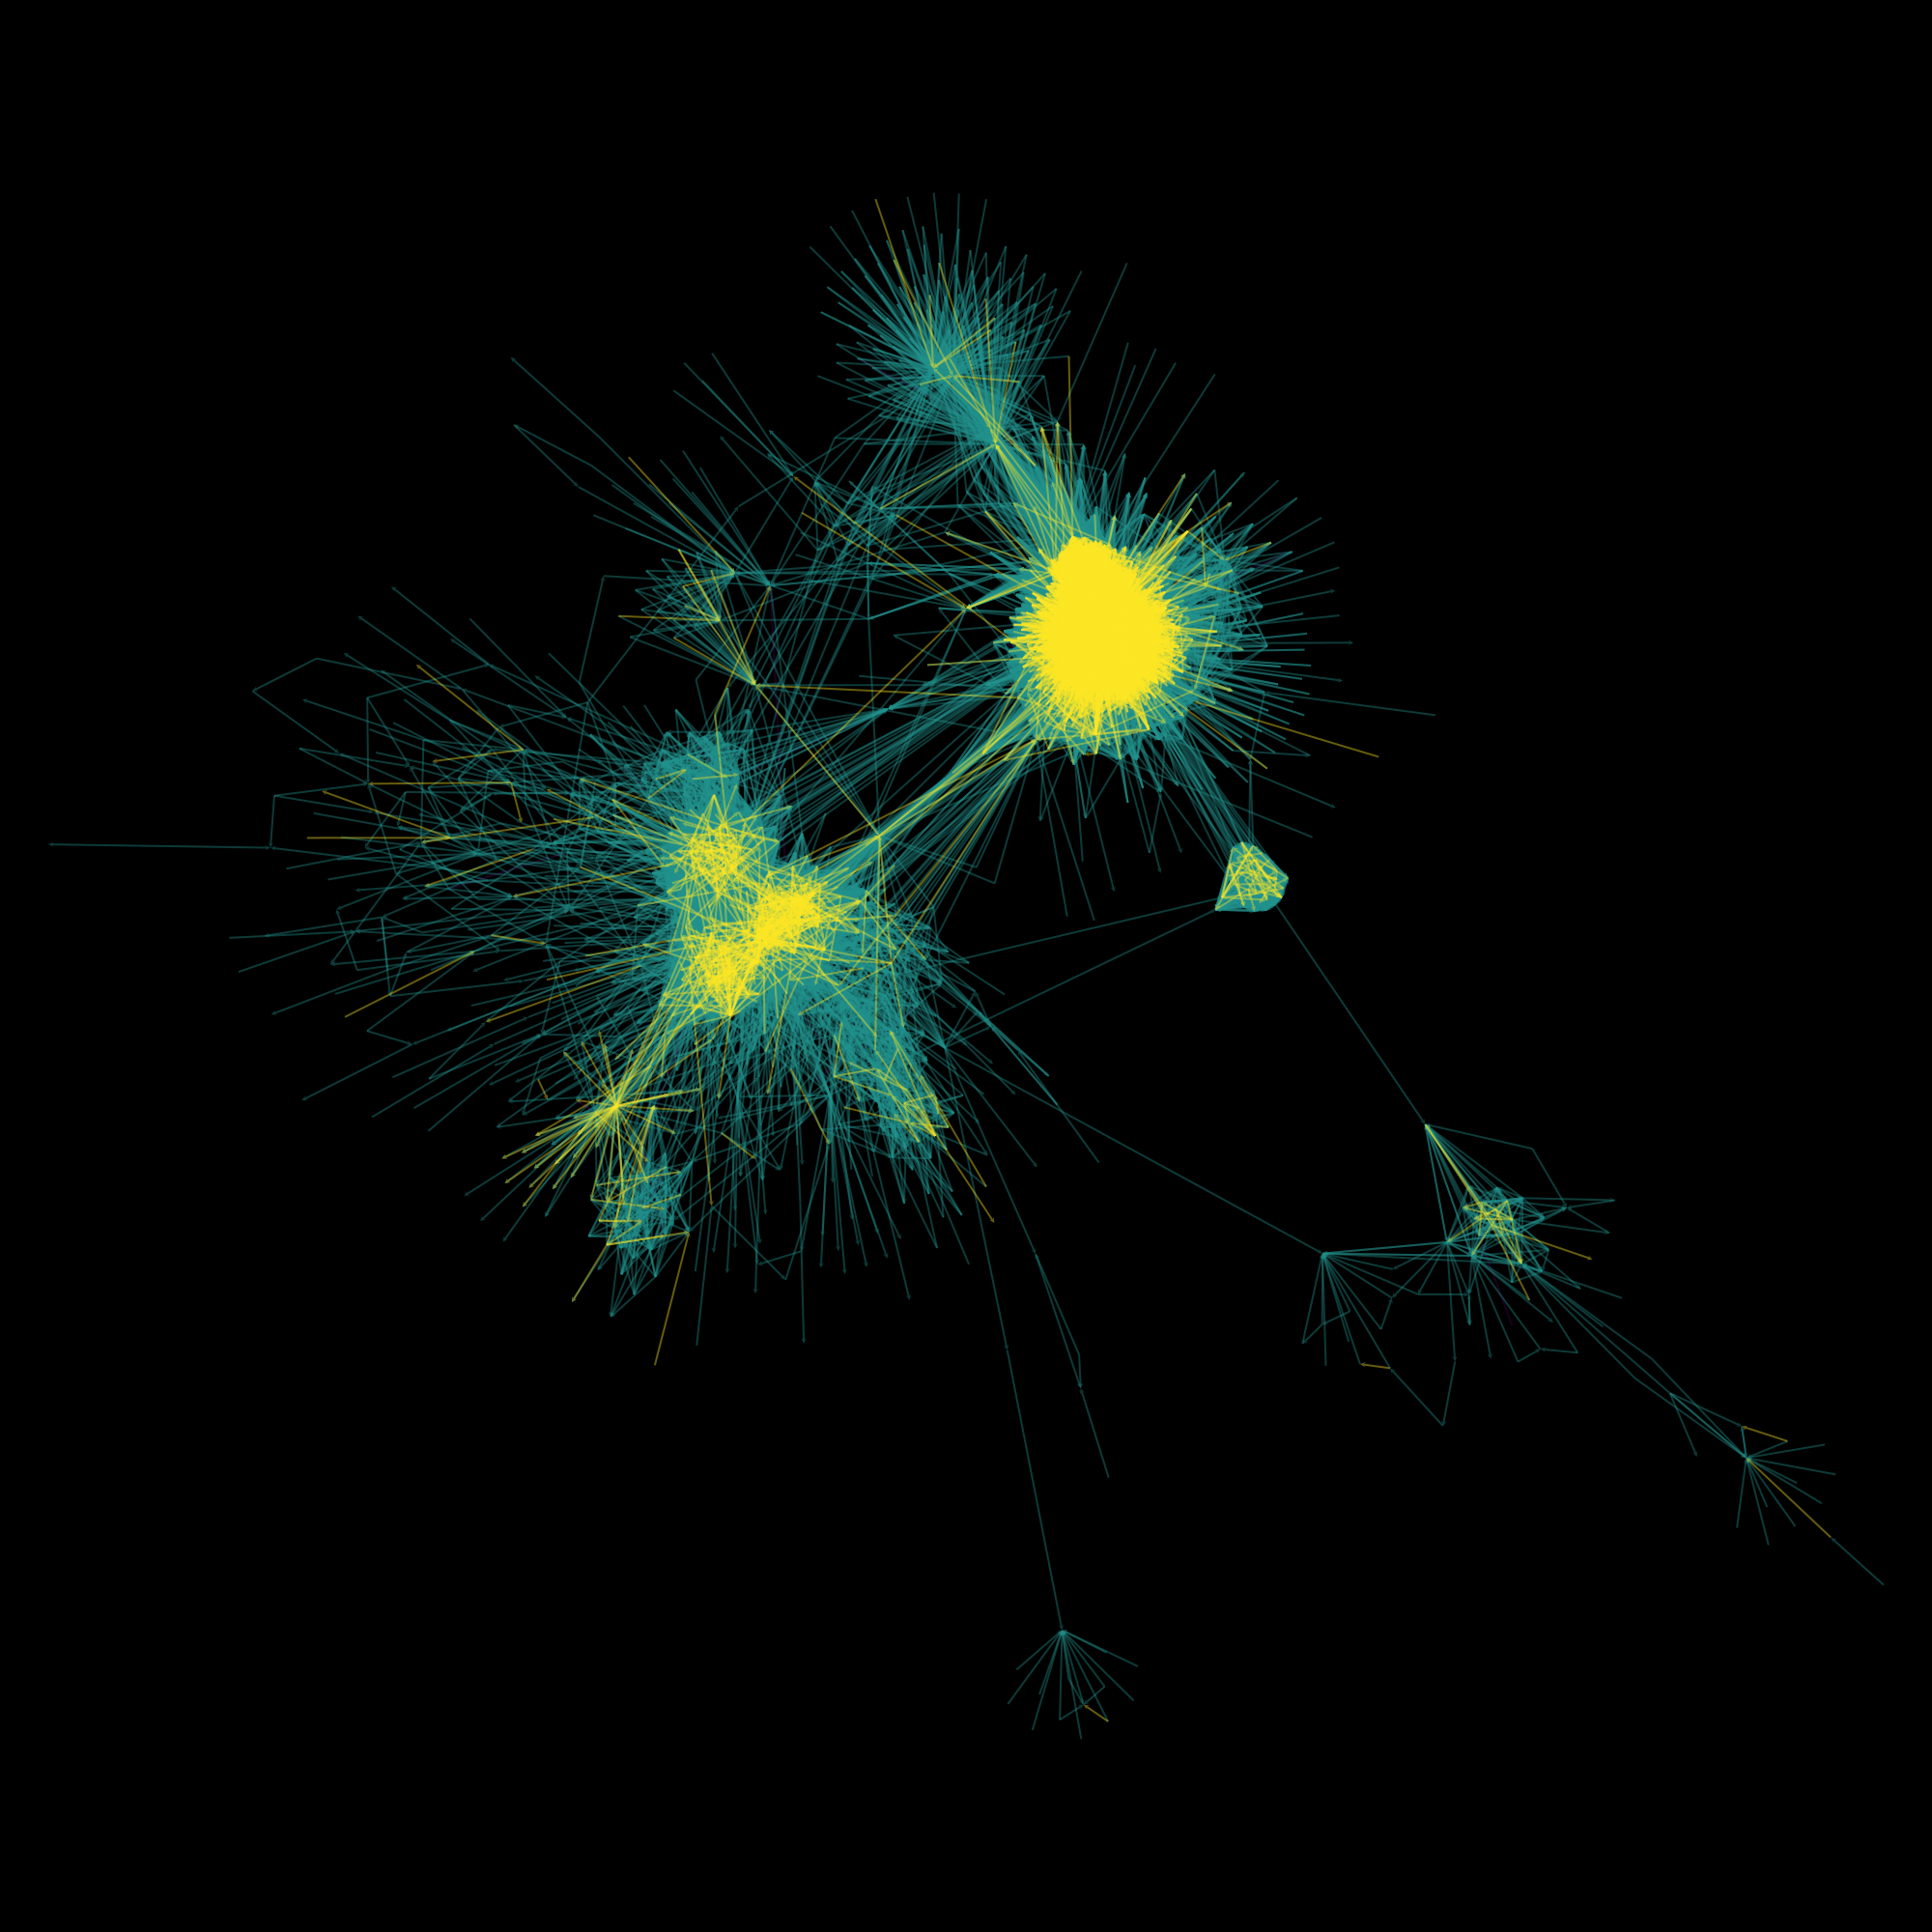

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7efd71c92630, at 0x7efd71c96f60>

In [13]:
eprop = largest_comp.ep["n_weights"]

gt.graph_draw(
    largest_comp,
    pos=pos,
    output_size=(2000, 2000),
    edge_color=eprop,
    ecmap=(matplotlib.cm.viridis, 0.4),
    eorder=eprop,
    edge_pen_width=2,
    vertex_size=0,
    bg_color=[0, 0, 0, 1],
)

### Visualizing the other Relationship Types

We'll loop through all the different type of edges and create a visualization with each type. We'll use the `GraphView` again to only display nodes that have at least one of that specific type of relationship, and only edges that have that specific weight.

RT


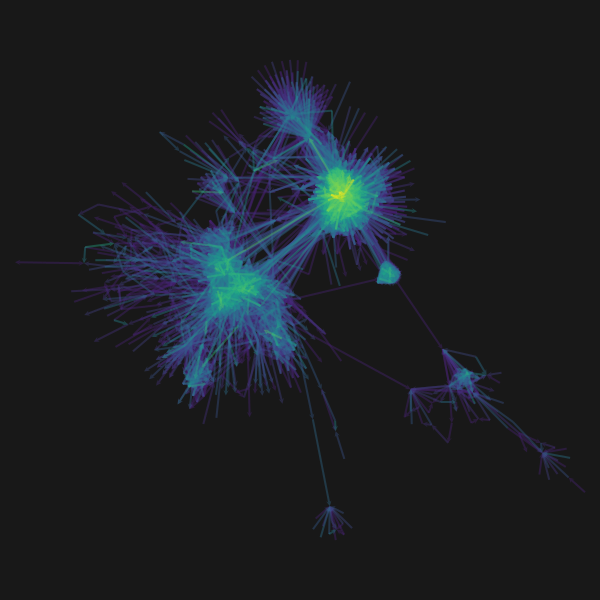

Mention


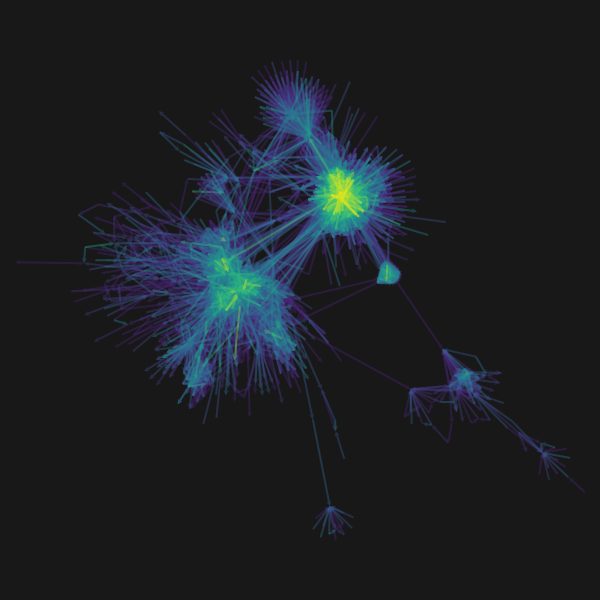

Reply


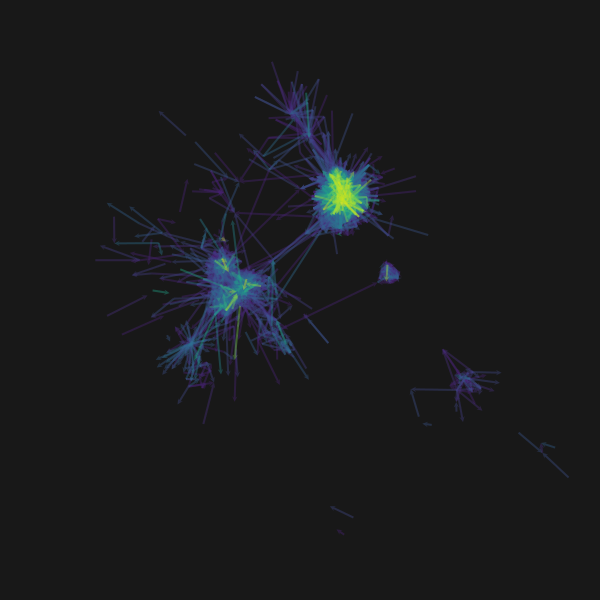

In [14]:
edge_weights_log_iter = [
    ("RT", "rt_weights_log"),
    ("Mention", "mention_weights_log"),
    ("Reply", "reply_weights_log"),
]

for weight in edge_weights_log_iter:
    print(weight[0])
    eprop = largest_comp.ep[weight[1]]
    vfilt = largest_comp.degree_property_map("total", weight=eprop).a != 0.0
    efilt = eprop.a > 0.0
    view = gt.GraphView(largest_comp, vfilt=vfilt, efilt=efilt)
    gt.graph_draw(
        view,
        pos=pos,
        output_size=(600, 600),
        edge_color=eprop,
        ecmap=(matplotlib.cm.viridis, .4),
        eorder=eprop,
        edge_pen_width=2,
        vertex_size=0,
        bg_color=[0, 0, 0, .9],
    )

### Edge Weights Discussion
These images indicate that most nodes are connected via RTs and mentions. It appears as if the mention weights are little more evenly distributed, with several relationships having weights near the maximum in comparison. We can supplement this analysis with the data from our edges dataset.

In [15]:
edges[["rt_weight", "mention_weight", "reply_weight", ]].apply(np.log1p).describe()

,rt_weight,mention_weight,reply_weight
count,181015.000000,181015.000000,181015.000000
mean,1.218927,1.337486,0.157803
std,0.868187,0.855629,0.525022
min,0.000000,0.000000,0.000000
25%,0.693147,0.693147,0.000000
50%,0.693147,1.098612,0.000000
75%,1.609438,1.791759,0.000000
max,7.393263,7.428927,7.606885


It appears RTs and mentions have a similar range, but the difference between the 50th percentile values indicates the more even distribution among the mentions.

Let's explore the relationships between the weights as well.

In [16]:
edges[["rt_weight", "reply_weight", "mention_weight"]].corr()

,rt_weight,reply_weight,mention_weight
rt_weight,1.000000,0.013421,0.706765
reply_weight,0.013421,1.000000,0.618214
mention_weight,0.706765,0.618214,1.000000


## Exporting the Graph
At this point, we'll conclude our brief analysis and export the graph.

Saving is easy, but before we save, we need to be sure that we've internalized all of the `PropertyMap` attributes to the graph. If they aren't set as "internal" to the graph, they don't get saved with the graph.

In [17]:
largest_comp.save("./data/ira_largest_component.gt")

In [18]:
# Check that graph loads
loaded_graph = gt.load_graph("./data/ira_largest_component.gt")

assert loaded_graph.num_vertices() == largest_comp.num_vertices()
assert loaded_graph.num_edges() == largest_comp.num_edges()

# check property maps for edges and vertices
assert all((prop in loaded_graph.ep) for prop in largest_comp.ep.keys())
assert all((prop in loaded_graph.vp) for prop in largest_comp.vp.keys())

del loaded_graph